In [1]:
## Matplotlib
import matplotlib.pyplot as plt
import numpy as np
from  scipy import stats 
from  scipy.stats import norm
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from pylab import figure, axes, pie, title, show, savefig

## Astropy
from astropy.io import ascii
from astropy.io import fits  ### importamos fits de astropy.io
from astropy.table import Table  ## importamos Table de astropy.table
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles

from astropy.cosmology import LambdaCDM

from astropy import units as u #Units and constants
import astropy.constants as cons
from astropy import wcs

## Pandas
import pandas as pd

## Request (download images from the cloud)
import requests
from io import BytesIO

## Image
import matplotlib.image as mpimg
from PIL import Image

## Smoothing
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, Tophat2DKernel, Box2DKernel, interpolate_replace_nans   
from scipy.signal import convolve as scipy_convolve
from astropy.convolution import convolve, convolve_fft

In [2]:
##Read the xray image
hdulist_xray = fits.open('Abell2670_broad_flux.img')
scidata_xray = hdulist_xray[0].data  ## data
head_xray = hdulist_xray[0].header  ## header information
wcs_xray = wcs.WCS(head_xray)

Set MJD-OBS to 53135.087454 from DATE-OBS.
Set MJD-END to 53135.565602 from DATE-END'. [astropy.wcs.wcs]


In [3]:
wcs_xray

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 358.5594493244  -10.402907605762  
CRPIX : 1774.625  1774.625  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.00054666666666668  0.00054666666666668  
NAXIS : 3250  3250

## DISPLAYING X-RAY ON OPTICAL IMAGE 

In [4]:
RA_BCG, DEC_BCG = 358.55708333, -10.4192221 ## Coordinates for A2670's BCG (degrees) or the center of your image
z=0.076 ## A2670's redshift
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7) ## Here I work with this ΛCDM cosmology 

In [5]:
## Function to cut the x-ray image with a defined FOV
def cut_xray_image(ra_bcg, dec_bcg, fov, fov_units): ## Here we use ra_bcg and dec_bcg in degrees. FOV can be in degrees, arcmins, arcsegs 
    
    ## fov: field of view (int or float) , fov_units: units of fov (string)
    ## Independently the unit of the FOV the function works in degrees
    if fov_units == "deg" or fov_units == "°" or fov_units == "degrees":
        FOV = fov ## fov in degrees
    elif fov_units == "am" or fov_units == "'" or fov_units == "arcmin":
        FOV = fov/60. ## fov in degrees
    elif fov_units == "as" or fov_units == "''" or fov_units == "arcsec":    
        FOV = (fov/60.)/60. ## fov in degrees
       
    # bcg coordinates
    bcg = np.array([ra_bcg,dec_bcg],float)    ## bcg coordinates in an array
    bcg_pix = wcs_xray.all_world2pix([bcg],0) ## converting bcg coordinates in pixels
    bcg_ra_pix, bcg_dec_pix = round(bcg_pix[0][0]), round(bcg_pix[0][1]) ## bcg coordinates in pixels
        
    #offset and fovs to cut       
    fovs = np.array([ra_bcg + FOV/2., dec_bcg + FOV/2.],float) ### Half of FOV from ra_bcg y dec_bcg (degrees)
    fovs_pixs = wcs_xray.all_world2pix([fovs],0) ### Converting half FOVs points in pixels 
    fov_pix_x, fov_pix_y = round(fovs_pixs[0][0]), round(fovs_pixs[0][1]) #Half FOVs points in pixels
        
    ## We cut the wcs (we only need ONE offset)
    offset = abs(bcg_ra_pix-fov_pix_x)
    wcs_xray_cut = wcs_xray[bcg_dec_pix-offset:bcg_dec_pix+offset,bcg_ra_pix-offset:bcg_ra_pix+offset]
           
    ##smoothed with ds9 scale
    kernel = Gaussian2DKernel(5) ## Usamos una gaussiana 
    a=10000.
    xray_scale = np.log(a*scidata_xray+1)/(np.log(a))
    astropy_conv = convolve(xray_scale, kernel)
    astropy_conv_cut = astropy_conv[bcg_dec_pix-offset:bcg_dec_pix+offset,bcg_ra_pix-offset:bcg_ra_pix+offset]
    
    ### The function returns 
    return wcs_xray_cut, astropy_conv_cut, fov, fov_units, FOV*60*60


## Function to plot points on the image
def points(ra, dec, projection): ## ra, dec in degrees
    
    RA, DEC = ra, dec
    coords_array = np.array([ra,dec],float)
    
    wcs_xray = projection
    coords_pix = wcs_xray.all_world2pix([coords_array],0)
    
    RA_PIX, DEC_PIX = coords_pix[0][0], coords_pix[0][1]
    return round(RA_PIX), round(DEC_PIX)


## Function to define the size of the scale line
def scale_line(scale,scale_unit):
    
    if scale_unit == "am" or scale_unit == "'" or scale_unit == "arcmin":
        scale_kpc = cosmo.kpc_proper_per_arcmin(z)*scale*u.arcmin
        scale_deg = scale/60.
        
    elif scale_unit == "as" or scale_unit == "''" or scale_unit == "arcsec":    
        scale_kpc = cosmo.kpc_proper_per_arcmin(z)*scale*(60**-1)*u.arcmin
        scale_deg = (scale/60.)/60.
        
    elif scale_unit == "deg" or scale_unit == "°" or scale_unit == "degrees":
        scale_kpc = cosmo.kpc_proper_per_arcmin(z)*scale*60*u.arcmin
        scale_deg = scale

    c1 = SkyCoord(RA_BCG*u.deg, DEC_BCG*u.deg,frame='icrs')
    c2 = SkyCoord((RA_BCG-scale_deg)*u.deg, DEC_BCG*u.deg,frame='icrs')
    c2_ra_pix, c2_dec_pix = points(RA_BCG-scale_deg,DEC_BCG, PROJECTION)
    sep_deg = c1.separation(c2)
    sep_pix = abs(c2_ra_pix - ra_bcg_pix)
    
    return sep_pix, scale_kpc.value
    
    

### We start defining the FOV that we want (it can be in degrees, arcmin or arcsec)

In [6]:
## I wanted a FOV of 5'x 5'
FoV, FoV_units = 5, 'am' ## deg, arcmin or arcsec (string) 

In [7]:
### Here we use the function to zoom the xray image
PROJECTION, CONTOURS, FOV, FOV_UNITS, FOV_ARCS = cut_xray_image(RA_BCG, DEC_BCG, FoV, FoV_units) ## (ra_bcg_deg, dec_bcg_deg, fov, fov_units)
print("The image have a FOV of",FOV_ARCS,"X",FOV_ARCS,"arcsec")


The image have a FOV of 300.0 X 300.0 arcsec


In [8]:
### Downloading the legacy image
Size_pix = 3000 ## Size of pixel in Legacy Survey, I use this large value in order to don't lose resolution
Size_arcs = FOV_ARCS  ## I use the FOV in arcsec to compute the pixscale in arcsec/pixels
PixScale = Size_arcs/Size_pix ## Pixel scale for the LS image

img = requests.get('https://www.legacysurvey.org/viewer/cutout.jpg?ra='+str(RA_BCG)+'&dec='+str(DEC_BCG)+'&layer=ls-dr9&size='+str(Size_pix)+'&pixscale='+str(PixScale))
leg_img = Image.open(BytesIO(img.content))

## to save the image
#with open('image.jpg','wb') as f:
    #f.write(img.content)

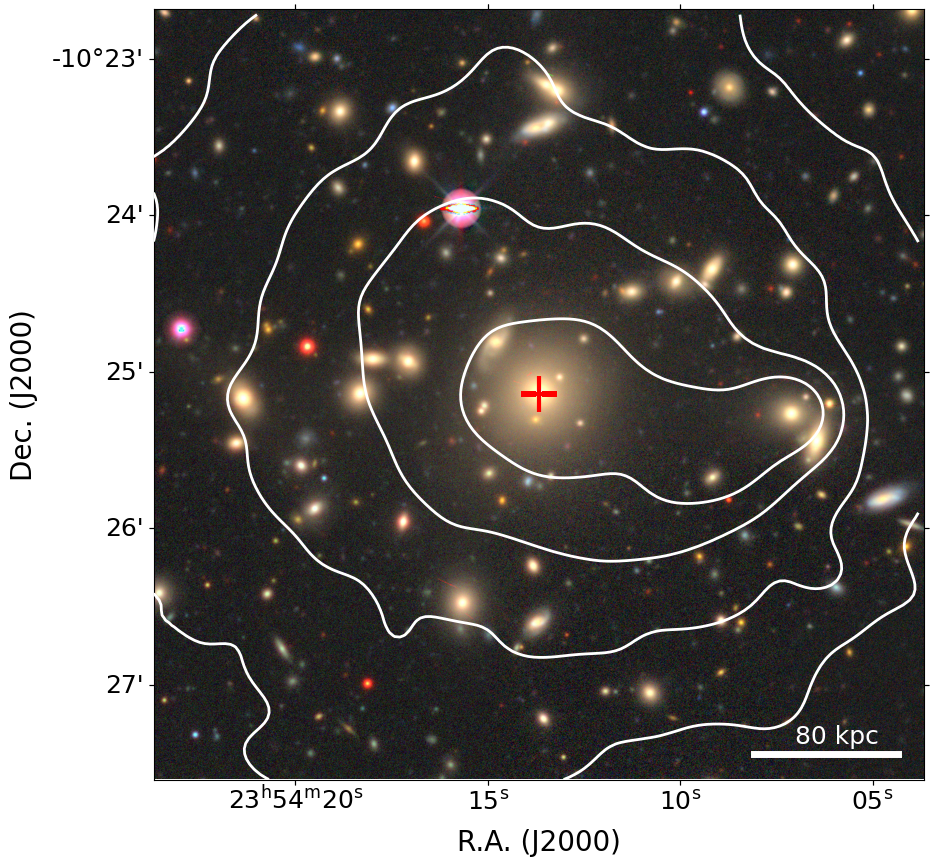

In [9]:
#%matplotlib notebook
%matplotlib inline

fig = plt.figure(figsize=(10.,10.))
#ax = fig.add_subplot(111, projection=PROJECTION)  # Defines the projection based on line 15 which comes from header

ax = fig.add_subplot(projection=PROJECTION)
ax.contour(CONTOURS,levels=np.logspace(-5.2,-1.,17), colors='white', alpha=1,linewidths=2) ## PLOT X-RAY CONTOURS
ax.imshow(leg_img, extent=[0, np.shape(CONTOURS)[0], 0, np.shape(CONTOURS)[0]]) ## PLOT OPTIC IMAGE FROM LEGACY

ra_bcg_pix, dec_bcg_pix = points(RA_BCG,DEC_BCG, PROJECTION) ## BCG coordinates (pixels)
ax.scatter(ra_bcg_pix, dec_bcg_pix,marker='+',color='red',s=700,lw=3) ### PLOT BCG

##--------------------- PLOT THE SCALE LINE (in kpc)-------------------------------
#Here we decide what scale to use (I'm using 1 arcmin)
sep_pixels, sc_kpc = scale_line(0.9255,'am') ## (value,unit) 
#NOTE: According your scale you'll need to edit the position and size for the next two lines of the code
ax.plot([145,145-sep_pixels],[5,5],'-',lw=5,color='white') ## plot the line
ax.annotate(str(round(sc_kpc))+" kpc",(125,7),color='white',fontsize=18) ## plot the value (kpc) as annotation


### plot stuff
ax.set_xlabel('R.A. (J2000)',fontsize=20)
ax.set_ylabel('Dec. (J2000)',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
#plt.savefig("Xray+Optic.eps",bbox_inches="tight")
plt.savefig("Xray+Optic.png",transparent=True,bbox_inches="tight")
plt.show()

